<a href="https://colab.research.google.com/github/AtomZa/OptizySimulation/blob/main/simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import jv # Bessel function of the first kind
from scipy.special import kv # Modified Bessel function of the second kind
from scipy.special import kve # Exponentially scaled modified Bessel function of the second kind
from scipy.optimize import root_scalar # Root finding algorithm
import scipy.integrate as integrate
import math

# Optical Parameters

In [2]:
ncoresmf = 1.4504;
ncladdingsmf = 1.447;
asmf = 4.1;
ncoremmf = 1.443;
nmedium = 1.04641231840654;
ncladdingmmf = nmedium;
ammf = 62.5;
zmmf = 57713;
epscoresmf = math.pow(ncoresmf, 2);
epscladdingsmf = math.pow(ncladdingsmf, 2);
epscoremmf = math.pow(ncoremmf, 2);
epscladdingmmf = math.pow(ncladdingmmf, 2);
lamb = 0.3;
k0 = 2*math.pi/lamb;
aair = 72.5;
dx = 5e-6;
ifinal = ((ncoresmf - ncladdingsmf)/dx);

# Find Effective Index

In [3]:
def characeqnsmf(neff,epscoresmf,epscladdingsmf,k0,asmf):
    return ((jv(0,k0*asmf*math.sqrt(epscoresmf - math.pow(neff,2))))*(k0*asmf*math.sqrt(math.pow(neff,2) - epscladdingsmf))*(kv(1,k0*asmf*math.sqrt(math.pow(neff,2) - epscladdingsmf)))) - ((kv(0,k0*asmf*math.sqrt(math.pow(neff,2) - epscladdingsmf)))*(k0*asmf*math.sqrt(epscoresmf - math.pow(neff,2)))*(jv(1,k0*asmf*math.sqrt(epscoresmf - math.pow(neff,2)))));

In [4]:
neffarrsmf = 0;
for i in range(round(ifinal)):
  try:
    sol = root_scalar(characeqnsmf, args=(epscoresmf, epscladdingsmf, k0, asmf), method='toms748', bracket=[ncoresmf-((i+1)*dx), ncoresmf-(i*dx)])
    neffarrsmf = sol.root
    break
  except:
    pass

# Singlemode

In [5]:

usmf =  k0*asmf*math.sqrt(math.pow(ncoresmf,2) - math.pow(neffarrsmf,2));   
wsmf =  k0*asmf*math.sqrt(math.pow(neffarrsmf,2) - math.pow(ncladdingsmf,2));

In [6]:
rarrsmf = np.arange(-asmf, asmf, 0.01);
rarrcladding1 = np.arange(-ammf, -asmf-0.01, 0.01);
rarrcladding2 = np.arange(asmf+0.01, ammf, 0.01);
rarrair1 = np.arange(-aair, -ammf-0.01, 0.01);
rarrair2 = np.arange(ammf+0.01, aair, 0.01);
rarrall = np.concatenate((rarrair1, rarrcladding1, rarrsmf, rarrcladding2, rarrair2), axis=None)

In [7]:
ecoresmf = jv(0,(usmf*rarrsmf/asmf));
c = (jv(0,usmf))/(kv(0,wsmf));
ecladdingsmf2 = c*(kv(0,(wsmf*rarrcladding2/asmf)));
ecladdingsmf1 = np.zeros(np.size(ecladdingsmf2))
eair1 = np.zeros(np.size(rarrair1));
eair2 = np.zeros(np.size(rarrair2));
eall =  np.concatenate((eair1, ecladdingsmf1, ecoresmf, ecladdingsmf2, eair2), axis=None)

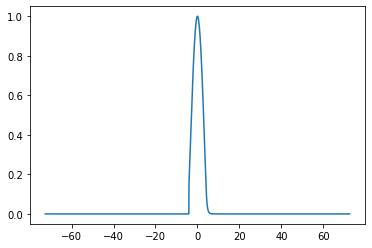

In [8]:
plt.plot(rarrall,eall)
plt.show()

# Multimode

In [9]:
ifinal = ((ncoremmf - ncladdingmmf)/dx);
neffarrmmf = np.zeros((1,round(ifinal)));

In [10]:
def characeqnmmf(neff,epscoremmf,epscladdingmmf,k0,ammf):
    return ((jv(0,k0*ammf*math.sqrt(epscoremmf - math.pow(neff,2))))*(k0*ammf*math.sqrt(math.pow(neff,2) - epscladdingmmf))*(kve(1,k0*ammf*math.sqrt(math.pow(neff,2) - epscladdingmmf)))) - ((kve(0,k0*ammf*math.sqrt(math.pow(neff,2) - epscladdingmmf)))*(k0*ammf*math.sqrt(epscoremmf - math.pow(neff,2)))*(jv(1,k0*ammf*math.sqrt(epscoremmf - math.pow(neff,2)))));

In [11]:
for i in range(round(ifinal)):
  try:
    sol = root_scalar(characeqnmmf, args=(epscoremmf, epscladdingmmf, k0, ammf), method='toms748', bracket=[ncladdingmmf + (i*dx), ncladdingmmf + ((i+1)*dx)])
    neffarrmmf[0,i] = sol.root
  except:
    neffarrmmf[0,i] = np.nan
    pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [12]:
neffarrmmf= neffarrmmf[:, ~np.isnan(neffarrmmf).any(axis=0)]
neffarrmmf = np.flip(neffarrmmf, axis=None)
mmfmode = np.arange(0, np.size(neffarrmmf), 1)

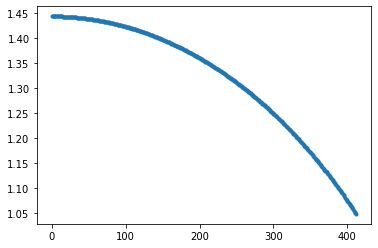

In [13]:
plt.plot(mmfmode, np.transpose(neffarrmmf), '.')
plt.show()

## Coupling Efficiency

In [14]:
uarrmmf = np.zeros((1, max(neffarrmmf.shape)), dtype=float)
warrmmf = np.zeros((1, max(neffarrmmf.shape)), dtype=float)
carr = np.zeros((1, max(neffarrmmf.shape)), dtype=float)

for j in range(max(neffarrmmf.shape)):
  uarrmmf[0,j] = k0*ammf*math.sqrt(ncoremmf**2 - neffarrmmf[0,j]**2);
  warrmmf[0,j] = k0*ammf*math.sqrt( neffarrmmf[0,j]**2 - ncladdingmmf**2);
  carr[0,j] = (jv(0, uarrmmf[0,j])/(kve(0, warrmmf[0,j])))

In [15]:
pj = np.zeros((1, max(neffarrmmf.shape)), dtype=float)
aj = np.zeros((1, max(neffarrmmf.shape)), dtype=float)

csmf = (jv(0,usmf))/(kv(0,wsmf));   
ecladdingsmf = csmf*(kv(0,(wsmf*rarrcladding2/asmf)));
eair = ecladdingsmf[-1]

for ii in range(max(neffarrmmf.shape)):
  funpj1 = lambda r : ((np.absolute(jv(0,(uarrmmf[0,ii]*r/ammf))))**2)*r
  funpj2 = lambda r : ((np.absolute(carr[0,ii]*kv(0,(warrmmf[0,ii]*r/ammf))))**2)*r
  pj[0, ii] = ((integrate.quad(funpj1,0,ammf)[0])+(integrate.quad(funpj2,ammf,ammf*3))[0])*2*math.pi

  funpaj1 = lambda r : ((jv(0,(usmf*r/asmf)))*(np.conj(jv(0,(uarrmmf[0,ii]*r/ammf)))))*r
  funpaj2 = lambda r : ((csmf*kv(0,(wsmf*r/asmf)))*(np.conj(jv(0,(uarrmmf[0,ii]*r/ammf)))))*r
  funpaj3 = lambda r : ((eair)*(np.conj(carr[0,ii]*kv(0,(warrmmf[0,ii]*r/ammf)))))*r;

  aj[0, ii] = (integrate.quad(funpaj1,0,asmf)[0] + integrate.quad(funpaj2,asmf,ammf)[0] + integrate.quad(funpaj3,ammf,ammf*3)[0])*2*math.pi/pj[0,ii]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  # This is added back by InteractiveShellApp.init_path()


In [16]:
zarr = np.expand_dims(np.arange(0, 50000, 50), axis=0)
betammf = neffarrmmf*k0
funescore = lambda r : ((np.absolute(jv(0,(usmf*r/asmf))))**2)*r
funesclad = lambda r : ((np.absolute(csmf*kv(0,(wsmf*r/asmf))))**2)*r
ps = (integrate.quad(funescore,0,asmf)[0] + integrate.quad(funesclad,asmf,ammf)[0])*(2*math.pi)
ajbar = aj*(np.sqrt(pj/ps))

P1 = np.transpose(((betammf-np.transpose(betammf))*1j))
P1 = P1.flatten()*np.transpose(zarr)
P2 = np.log((ajbar**2)*np.transpose(((np.conj(ajbar))**2)))
P2 = P2.flatten()
P3 = np.absolute(np.sum(np.exp(P2+P1), axis=1))
P3.shape

(1000,)

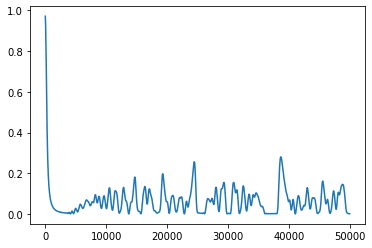

In [17]:
plt.plot(np.transpose(zarr), P3)
plt.show()